# Processing your Eclipse Photo with SunPy

Requirements
* Python 3
* matplotlib
* scipy
* sunpy >= 0.8
* skimage
* exifread
* astropy

In [1]:
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import scipy.ndimage as ndimage
from skimage.transform import hough_circle, hough_circle_peaks

import astropy.wcs
from astropy.coordinates import EarthLocation, SkyCoord
import astropy.units as u

import sunpy
import sunpy.map
import sunpy.coordinates

import exifread # to read information from the image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
sunpy.system_info()

 SunPy Installation Information


###########
 General
###########
Time : Tuesday, 22. August 2017 01:55AM UT
System : Darwin
Processor : i386
Arch : 64bit
SunPy : 0.8.dev8766
SunPy_git : 6efb67eddbb70b210458a909fddd139ff74e2ffd
OS: Mac OS X 10.12.6 (i386)


###########
 Required Libraries 
###########
Python: 3.5.2
NumPy: 1.13.1
SciPy: 0.19.1
matplotlib: 2.0.2
Astropy: 2.0
Pandas: 0.20.2


###########
 Recommended Libraries 
###########
beautifulsoup: 4.6.0
PyQt: NOT INSTALLED
SUDS: 0.6
Sqlalchemy: 1.1.5
Requests: 2.18.2


Replace the following with your photo filename. Here we are using an eclipse photo originally taken by Henke Bril taken in Salloum, Egypt on March 29, 2006. We've hacked the EXIF info to make it seem like it was taken for this eclipse. We will update this with a real 2017 Eclipse photo as soon as we have one!

In [3]:
f = '../sample-photos/total_solar_eclipse2017.jpg'

## First let's try to get some metadata from the file

In [4]:
tags = exifread.process_file(open(f, 'rb'))

In [5]:
# the following functions will help us get GPS data from the EXIF data if it exists
def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = exif_data.get('GPS GPSLatitude', None)
    gps_latitude_ref = exif_data.get('GPS GPSLatitudeRef', None)
    gps_longitude = exif_data.get('GPS GPSLongitude', None)
    gps_longitude_ref = exif_data.get('GPS GPSLongitudeRef', None)

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon

In [6]:
if "EXIF ExposureTime" in tags:
    exposure_tag = tags['EXIF ExposureTime']
    exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
    print("Exposure time of {0} found!".format(exposure_time))
if "Image Artist" in tags:
    author_str = tags['Image Artist'].values
    print("Author name of {0} found!".format(author_str))
if "EXIF DateTimeOriginal" in tags:
    datetime_str = tags['EXIF DateTimeOriginal'].values.replace(' ', ':').split(':')
    time = datetime(int(datetime_str[0]), int(datetime_str[1]), 
                    int(datetime_str[2]), int(datetime_str[3]),
                    int(datetime_str[4]), int(datetime_str[5]))
    print("Image time of {0} found!".format(str(time)))
if "Image Model" in tags:
    camera_model_str = tags['Image Model'].values
    print("Camera model of {0} found!".format(camera_model_str))
lat, lon = get_exif_location(tags)
if ((lat != None) and (lon != None)):
    gps = [lat, lon] * u.deg
    print("Found GPS location of {0}, {1} found!".format(gps[0], gps[1]))

Exposure time of 0.016666666666666666 s found!
Author name of Steven D. Christe found!
Image time of 2017-08-21 11:27:13 found!
Camera model of Canon EOS 70D found!
Found GPS location of 44.30287222222222 deg, -116.08796944444444 deg found!


The following variables need to be defined. If they were not found in the EXIF data please define them below

In [7]:
# exposure_time = 0.1 * u.s
# camera_model_str = 'Canon 70D'
# author_str = 'Julius Berkowski'
time = datetime(2017, 8, 21, 17, 27, 13) # don't forget to convert your time to UTC!
#gps = [44.37197, -116.87393] * u.deg # latitude, longitude of Mann Creek, Idaho

## Read in the image data

In [8]:
# read in the image and flip it so that it's correct
im_rgb = np.flipud(matplotlib.image.imread(f))
# remove color info
im = np.average(im_rgb, axis=2)

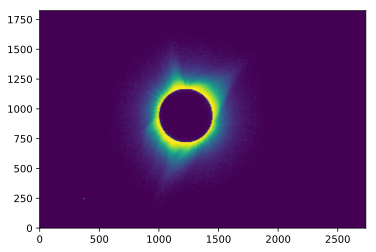

In [9]:
plt.imshow(im, origin='lower')

# Get info from the image

We need the following information from the image
* the location of the center of the Sun/Moon and 
* the scale of the picture which we get from the size of the Sun/Moon in pixels

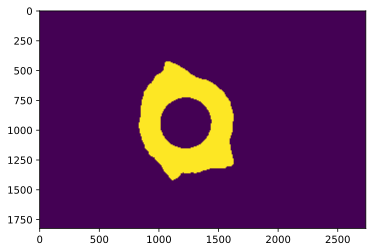

In [10]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)

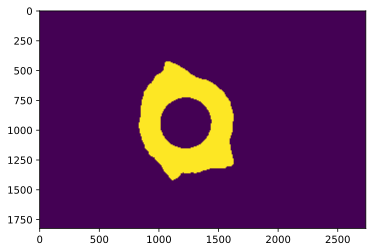

In [11]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im)

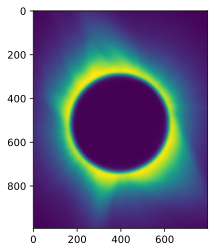

In [12]:
slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
roi = blur_im[slice_x, slice_y]
plt.imshow(roi)

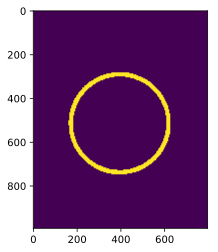

In [13]:
sx = ndimage.sobel(roi, axis=0, mode='constant')
sy = ndimage.sobel(roi, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob > (sob.mean() * 5))

In [14]:
from skimage.transform import hough_circle, hough_circle_peaks

hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 10)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent circle
accums, cy, cx, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
print(cx, cy, radii)

[514] [393] [ 223.]


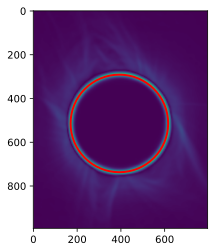

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(sob)
ax.add_patch(circ)
plt.show()

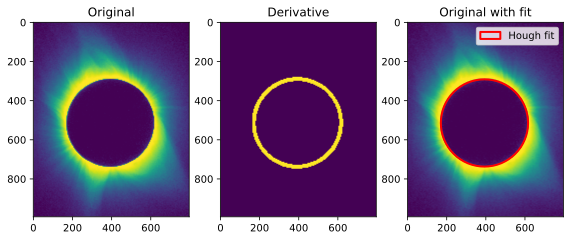

In [16]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9.5, 6))
ax[0].imshow(im[slice_x, slice_y])
ax[0].set_title('Original')
ax[1].imshow(sob > (sob.mean() * 5))
ax[1].set_title('Derivative')
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2, label='Hough fit')
ax[2].imshow(im[slice_x, slice_y])
ax[2].add_patch(circ)
ax[2].set_title('Original with fit')
plt.legend()

Now let's check it with the original image

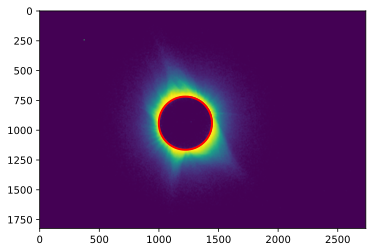

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
fudge_shift_x = 0 * u.pix # update this in case the fit needs to be shifted in x
fudget_shift_y = 0 * u.pix # update this in case the fit needs to be shifted in y
im_cx = (cx + slice_x.start) * u.pix + fudge_shift_x
im_cy = (cy + slice_y.start) * u.pix + fudget_shift_y
im_radius = radii * u.pix
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(im)
ax.add_patch(circ)
plt.show()

# Getting information about the Sun

Let's now get the distance between the Earth and the Sun at the time the photo was taken

In [18]:
dsun = sunpy.coordinates.get_sunearth_distance(time.isoformat())
print(dsun)

1.011546589067374 AU


The size of the Sun in the sky is then

In [19]:
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print(rsun_obs)

948.0099660006414 arcsec


The image plate scale is then

In [20]:
plate_scale = rsun_obs / im_radius
print(plate_scale)

[ 4.25116577] arcsec / pix


We also need the solar rotation angle

In [21]:
loc = EarthLocation(lat=gps[0], lon=gps[1])
fudge_angle = 0.0 * u.deg # update this in case your camera was not perfectly level.
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle

In [22]:
hgln_obs = 0 * u.deg # sunpy.coordinates.get_sun_L0(time)
hglt_obs = sunpy.coordinates.get_sun_B0(time)
print("{0} {1}".format(hglt_obs, hgln_obs))

6.9281560172684085 deg 0.0 deg


# Define your WCS object and header

In [23]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crpix = [im_cy[0].value, im_cx[0].value]
w.wcs.cdelt = np.ones(2) * plate_scale.to('arcsec/pix').value
w.wcs.crval = [0, 0]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
w.wcs.dateobs = time.isoformat()

Using this object we can now create the sunpy map header

In [24]:
header = dict(w.to_header())
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
header.update({'DSUN_OBS': dsun.to('m').value})
header.update({'HGLN_OBS': hgln_obs.to('deg').value})
header.update({'HGLT_OBS': hglt_obs.to('deg').value})
header.update({'CTYPE1': 'HPLN-TAN'})
header.update({'CTYPE2': 'HPLT-TAN'})
header.update({'RSUN': dsun.to('m').value})
header.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})

Now add metadata about the photograph.

In [25]:
header.update({'AUTHOR': author_str})
header.update({'EXPTIME': exposure_time.to('s').value})
header.update({'TELESCOP': camera_model_str})
header.update({'INSTRUME': camera_model_str})
header.update({'DETECTOR': camera_model_str})

In [26]:
header

{'AUTHOR': 'Steven D. Christe',
 'CDELT1': 4.251165766819,
 'CDELT2': 4.251165766819,
 'CROTA2': -54.32892523530043,
 'CRPIX1': 1222.0,
 'CRPIX2': 941.0,
 'CRVAL1': 0.0,
 'CRVAL2': 0.0,
 'CTYPE1': 'HPLN-TAN',
 'CTYPE2': 'HPLT-TAN',
 'CUNIT1': 'arcsec',
 'CUNIT2': 'arcsec',
 'DATE-OBS': '2017-08-21T17:27:13',
 'DETECTOR': 'Canon EOS 70D',
 'DSUN_OBS': 151325215838.32706,
 'EXPTIME': 0.016666666666666666,
 'HGLN_OBS': 0.0,
 'HGLT_OBS': 6.9281560172684085,
 'INSTRUME': 'Canon EOS 70D',
 'LATPOLE': 90.0,
 'RSUN': 151325215838.32706,
 'RSUN_OBS': 948.0099660006414,
 'TELESCOP': 'Canon EOS 70D',
 'WCSAXES': 2}

# Creating SunPy Map

In [27]:
m = sunpy.map.Map((im, header))
m

SunPy Map
---------
Observatory:		 Canon EOS 70D
Instrument:		 Canon EOS 70D
Detector:		 Canon EOS 70D
Measurement:		 0.0
Wavelength:		 0.0
Observation Date:	 2017-08-21 17:27:13
Exposure Time:		 0.016667 s
Dimension:		 [ 2736.  1824.] pix
Coordinate System:	 helioprojective
Scale:			 [ 4.25116577  4.25116577] arcsec / pix
Reference Pixel:	 [ 1222.   941.] pix
Reference Coord:	 [ 0.  0.] arcsec

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

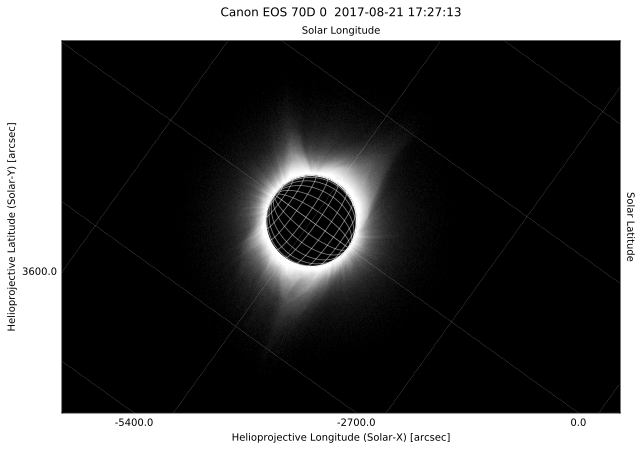

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Overplot the location of Regulus

In [29]:
regulus = SkyCoord(ra='10h08m22.311s', dec='11d58m01.95s', distance=79.3 * u.lightyear, frame='icrs').transform_to(m.coordinate_frame)

In [30]:
regulus

<SkyCoord (Helioprojective: obstime=2017-08-21 17:27:13, rsun=695508000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21 17:27:13): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  6.92815602,   1.51325216e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-4478.02801534,  1510.09937509,   7.50236078e+14)>

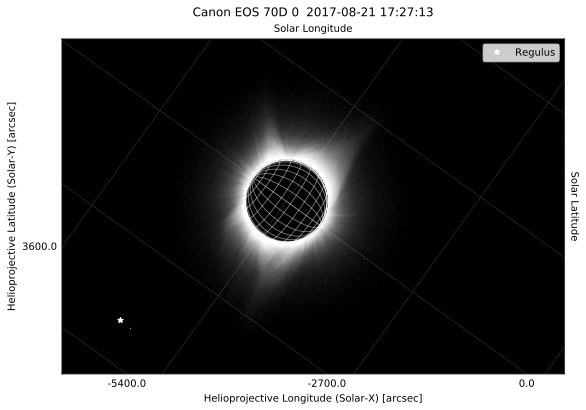

In [31]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, '*w', label='Regulus')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.legend()
plt.show()

We can see that the predicted location of regulus does not match which tells us that there a slight error in the angle. This is likely because the camera was not level with the horizon. Therefore we adjust to get it right.

In [32]:
fudge_angle = -3.0 * u.deg # update this in case your camera was not perfectly level.
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time) + fudge_angle
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
m = sunpy.map.Map((im, header))

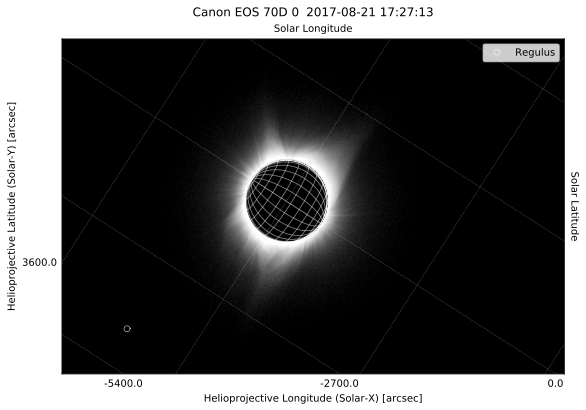

In [33]:
fig = plt.figure(figsize=(9,9))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, 'o', markeredgewidth=0.5, markeredgecolor='w', 
              markerfacecolor='None', label='Regulus')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.legend()
plt.show()

More tweaking could be done here to get thing right. We will leave that as an exercise for the reader!

# Plot an SDO AIA Image of the Sun on your photo

First we need to download the images

In [34]:
from sunpy.net import Fido, attrs as a
# Replace the time below with the time in UT of the eclipse
t = a.Time('2017-08-21 17:27:13', "2017-08-21 17:28:13")
aia_result = Fido.search(t, a.Instrument('AIA'), a.Wavelength(171*u.Angstrom))
files = Fido.fetch(aia_result)

[                                        ]========================================


In [35]:
files

[]

In [36]:
aia_map = sunpy.map.Map(files[0])
aia_map.plot()

IndexError: list index out of range

In [ ]:
# Create a composite map
cmap = sunpy.map.Map(m, aia_map, composite=True)
cmap.set_alpha(1, 0.5)

MORE COMING SOON!